In [1]:
## loading important libraries
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torchaudio
from sklearn.model_selection import train_test_split
import os
import sys
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment

from transformers import AutoFeatureExtractor
from datasets import load_dataset, Audio
from dataclasses import dataclass
from typing import Optional, Tuple
from transformers.file_utils import ModelOutput
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor, EvalPrediction, Trainer, is_apex_available
import numpy as np
from typing import Any, Dict, Union
import torch
from packaging import version
from torch import nn
import pandas as pd
from tqdm import tqdm
import torchaudio
import os
import IPython.display as ipd
from SilenceRemover import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor

import librosa
import IPython.display as ipd
import numpy as np
import pandas as pd

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading the autdio dataset from the directory
directory  = "/Users/yash/Desktop/MTP-2k23-24/TTS_data"
print(os.listdir(directory))

['eng', 'tel', 'mar', 'odi', 'asm', 'guj', 'hin', 'tam', 'kan', 'mal', 'ben']


In [ ]:
# # loading the autdio dataset from the directory
# directory  = "/Volumes/Yash Sharma/TTS_data"
# print(os.listdir(directory))
# # directory = "/kaggle/input/silencedaudiodata/SilencedAndOneSecondData"
# data = []
# for path in tqdm(os.listdir(directory)):
#     # now eplore the inner folder ,
#     #  path is actually the audio language
#     pathHere = os.path.join(directory, path);
#     count = 0;
#     if not path.startswith('.'):
#         for subFoldlers in os.listdir(pathHere):
#             if not subFoldlers.startswith('.'):
#                 pathHere2 = os.path.join(pathHere,subFoldlers);
#                 ## Now expploring all the available audio files inside 
#                 ## and if not corrupted storing then in dataframe 
#                 for audioSamples in os.listdir(pathHere2):
#                     ## extracto all req info
#                     name = audioSamples.split(".")[0]
#                     finalPath = os.path.join(pathHere2, audioSamples);
#                     try:
#                         # There are some broken files
#                         s, sr = torchaudio.load(finalPath)
#                         data.append({
#                             "name": name,
#                             "path": finalPath,
#                             "sampling_rate": sr,
#                             "language": path,
#                         });
#                         count = count +1;
#                     except Exception as e:
#                         print(str(path), e)
#                         pass
#         print(f'Total {count} samples loaded of {path} langueage dataset')

In [3]:
# loading the autdio dataset from the directory
directory  = "/Users/yash/Desktop/MTP-2k23-24/TTS_data"
print(os.listdir(directory))
# directory = "/kaggle/input/silencedaudiodata/SilencedAndOneSecondData"
data = []
for path in tqdm(os.listdir(directory)):
    # now eplore the inner folder ,
    #  path is actually the audio language
    pathHere = os.path.join(directory, path);
    count = 0;
    if not path.startswith('.'):
        for subFoldlers in os.listdir(pathHere):
            if not subFoldlers.startswith('.'):
                finalPath = os.path.join(pathHere,subFoldlers);
                name = subFoldlers.split(".")[0]
                try:
                    # There are some broken files
                    s, sr = torchaudio.load(finalPath)
                    data.append({
                        "name": name,
                        "path": finalPath,
                        "sampling_rate": sr,
                        "language": path,
                    });
                    count = count +1;
                except Exception as e:
                    print(str(path), e)
                    pass
        print(f'Total {count} samples loaded of {path} langueage dataset')

['eng', 'tel', 'mar', 'odi', 'asm', 'guj', 'hin', 'tam', 'kan', 'mal', 'ben']


  9%|▉         | 1/11 [00:01<00:11,  1.11s/it]

Total 200 samples loaded of eng langueage dataset


 18%|█▊        | 2/11 [00:01<00:08,  1.12it/s]

Total 100 samples loaded of tel langueage dataset


 27%|██▋       | 3/11 [00:02<00:05,  1.51it/s]

Total 100 samples loaded of mar langueage dataset


 36%|███▋      | 4/11 [00:02<00:03,  1.85it/s]

Total 100 samples loaded of odi langueage dataset


 45%|████▌     | 5/11 [00:02<00:02,  2.22it/s]

Total 100 samples loaded of asm langueage dataset


 55%|█████▍    | 6/11 [00:03<00:02,  2.09it/s]

Total 100 samples loaded of guj langueage dataset


 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

Total 100 samples loaded of hin langueage dataset


 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

Total 100 samples loaded of tam langueage dataset


 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

Total 100 samples loaded of kan langueage dataset


 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

Total 100 samples loaded of mal langueage dataset


100%|██████████| 11/11 [00:06<00:00,  1.67it/s]

Total 100 samples loaded of ben langueage dataset


In [4]:
## now lets form a dataframe from the data array
df = pd.DataFrame(data)
print("Total length of the Dataset: ", len(data))

Total length of the Dataset:  1200


In [5]:
df = df.sample(100, random_state=42).reindex()
df.head()

,name,path,sampling_rate,language
1178,train_bengalifemale_06583,/Users/yash/Desktop/MTP-2k23-24/TTS_data/ben/t...,48000,ben
865,train_tamilfemale_03238,/Users/yash/Desktop/MTP-2k23-24/TTS_data/tam/t...,48000,tam
101,train_kannadafullmale_05779,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng
439,text5715_female,/Users/yash/Desktop/MTP-2k23-24/TTS_data/odi/t...,48000,odi
58,train_assamesemale_06695,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng


In [6]:
## ecpplore dataset stats
print("Labels: ", df["language"].unique())
print()
df.groupby("language").count()[["path"]]

Labels:  ['ben' 'tam' 'eng' 'odi' 'mar' 'kan' 'tel' 'asm' 'hin' 'guj' 'mal']



,path
language,
asm,8
ben,8
eng,23
guj,7
hin,3
kan,6
mal,6
mar,15
odi,9


ID Location: 20
      Label: mar

Duration of the speech:  25.825958333333332
Original sampling Rate:  48000
After resampling: duration-> 8.608666666666666
Before  (1239646,) 
After:  (413216,)


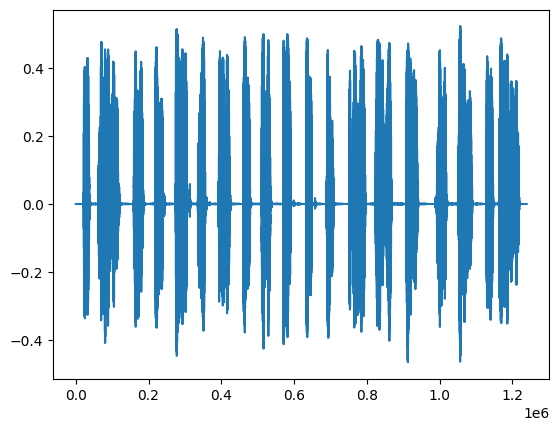

In [7]:
np.random.seed(33)
idx = np.random.randint(0, len(df))
sample = df.iloc[idx]
path = sample["path"]
label = sample["language"]


print(f"ID Location: {idx}")
print(f"      Label: {label}")
print()

speech, sr = torchaudio.load(path)
speech = speech[0].numpy().squeeze()
print("Duration of the speech: ",len(speech)/sr)
plt.plot(speech)
print("Original sampling Rate: ",sr)
# Resample the audio signal to a target sampling rate of 16,000 Hz
speech16k = librosa.resample(speech, orig_sr=sr, target_sr=16000)
print("After resampling: duration->",len(speech16k)/sr)
print("Before ",speech.shape,"\nAfter: ",speech16k.shape)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=sr)


In [8]:
# save_path = "/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/Outputs"
# # save_path = "/kaggle/working"

# # Split the data into train, eval, and test sets
# train_df, temp_df = train_test_split(df, test_size=0.2, random_state=101, stratify=df["language"])
# eval_df, test_df = train_test_split(temp_df, test_size=0.2, random_state=101, stratify=temp_df["language"])

# # Reset the index for all dataframes
# train_df = train_df.reset_index(drop=True)
# eval_df = eval_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

# # Save the train, eval, and test data as CSV files
# train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)
# eval_df.to_csv(f"{save_path}/eval.csv", sep="\t", encoding="utf-8", index=False)
# test_df.to_csv(f"{save_path}/test.csv", sep="\t", encoding="utf-8", index=False)

# print(train_df.shape)
# print(eval_df.shape)
# print(test_df.shape)



save_path = "/Users/yash/Desktop/MTP-2k23-24/Wav2vec-codes/Outputs"
# save_path = "/kaggle/working"

# Split the data into train, eval, and test sets
train_df = df

# Reset the index for all dataframes
train_df = train_df.reset_index(drop=True)

# Save the train, eval, and test data as CSV files
train_df.to_csv(f"{save_path}/train.csv", sep="\t", encoding="utf-8", index=False)

print(train_df.shape)


(100, 4)


In [9]:
# Loading the created dataset using datasets
# !pip install -q datasets==2.14.4
from datasets import load_dataset, load_metric

data_files = {
    "train": f"{save_path}/train.csv", 
    # "validation": f"{save_path}/eval.csv",
    # "test": f"{save_path}/test.csv"
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t")
train_dataset = dataset["train"]
# eval_dataset = dataset["validation"]
# test_dataset = dataset["test"]

print(train_dataset)
# print(eval_dataset)
# print(test_dataset)

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 411.17it/s]


Dataset csv downloaded and prepared to /Users/yash/.cache/huggingface/datasets/csv/default-f89e4ebfed10bf71/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 406.03it/s]

Dataset({
    features: ['name', 'path', 'sampling_rate', 'language'],
    num_rows: 100
})


In [10]:
train_dataset[0]

{'name': 'train_bengalifemale_06583',
 'path': '/Users/yash/Desktop/MTP-2k23-24/TTS_data/ben/train_bengalifemale_06583.wav',
 'sampling_rate': 48000,
 'language': 'ben'}

In [11]:
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)

@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None



class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
#         self.pooling_mode = config.pooling_mode
        self.pooling_mode = 'mean'
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy( self, hidden_states, mode="mean"):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward( self, input_values, attention_mask=None, output_attentions=None, output_hidden_states=None, return_dict=None,labels=None):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
        
    def extract_hidden_states(self, input_values, attention_mask=None, output_attentions=None, output_hidden_states=None):
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
        )

        # Extract the hidden states from the Wave2Vec2 model
        hidden_states = outputs.last_hidden_state
        return hidden_states


In [12]:
import librosa
from sklearn.metrics import classification_report

In [13]:
# We need to specify the input and output column
input_column = "path"
output_column = "language"

In [14]:
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f"A classification problem with {num_labels} classes: {label_list}")

A classification problem with 11 classes: ['asm', 'ben', 'eng', 'guj', 'hin', 'kan', 'mal', 'mar', 'odi', 'tam', 'tel']


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [16]:
model_name_or_path = "yashcode00/wav2vec2-large-xlsr-indian-language-classification-featureExtractor"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)
target_sampling_rate = processor.feature_extractor.sampling_rate

target_sampling_rate

16000

In [17]:
test = pd.read_csv(f"{save_path}/train.csv", sep="\t")
test.head()

,name,path,sampling_rate,language
0,train_bengalifemale_06583,/Users/yash/Desktop/MTP-2k23-24/TTS_data/ben/t...,48000,ben
1,train_tamilfemale_03238,/Users/yash/Desktop/MTP-2k23-24/TTS_data/tam/t...,48000,tam
2,train_kannadafullmale_05779,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng
3,text5715_female,/Users/yash/Desktop/MTP-2k23-24/TTS_data/odi/t...,48000,odi
4,train_assamesemale_06695,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng


In [18]:
test

,name,path,sampling_rate,language
0,train_bengalifemale_06583,/Users/yash/Desktop/MTP-2k23-24/TTS_data/ben/t...,48000,ben
1,train_tamilfemale_03238,/Users/yash/Desktop/MTP-2k23-24/TTS_data/tam/t...,48000,tam
2,train_kannadafullmale_05779,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng
3,text5715_female,/Users/yash/Desktop/MTP-2k23-24/TTS_data/odi/t...,48000,odi
4,train_assamesemale_06695,/Users/yash/Desktop/MTP-2k23-24/TTS_data/eng/t...,48000,eng
...,...,...,...,...
95,train_gujaratifemale_00336,/Users/yash/Desktop/MTP-2k23-24/TTS_data/guj/t...,48000,guj
96,train_assamesemale_05149,/Users/yash/Desktop/MTP-2k23-24/TTS_data/asm/t...,48000,asm
97,train_kannadafemale_00191,/Users/yash/Desktop/MTP-2k23-24/TTS_data/kan/t...,48000,kan
98,train_telugufemale_03567,/Users/yash/Desktop/MTP-2k23-24/TTS_data/tel/t...,16000,tel


In [19]:
# test_dataset

In [20]:
label2id={label: i for i, label in enumerate(label_list)},
id2label={i: label for i, label in enumerate(label_list)},
label_names = [id2label[0][i] for i in range(num_labels)]
label_names

['asm', 'ben', 'eng', 'guj', 'hin', 'kan', 'mal', 'mar', 'odi', 'tam', 'tel']

In [21]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech_array = torch.frombuffer(RemoveSilence(batch["path"]),dtype=torch.float32)
    speech_array = resampler(speech_array).squeeze().numpy()
    batch["speech"] = speech_array
    return batch

def predict(batch):
    features = processor(batch["speech"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
#     attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values).logits 
#         logits = model(input_values, attention_mask=attention_mask).logits 

    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    batch["predicted"] = pred_ids
    return batch


In [22]:
# y_pred = []
# y_true = []
# for batch in tqdm(train_dataset):
#     y_true.append(config.label2id[batch['language']])
#     y_pred.append(predictOne(batch['path']))

In [23]:
test_dataset = train_dataset.map(speech_file_to_array_fn)

In [24]:
def predictOne(batch):
    window_size = 16000
    silencedAudio = batch['speech']
    # print(silencedAudio)

    overlap = window_size // 2

    windows = [silencedAudio[i:i+window_size] for i in range(0, len(silencedAudio), window_size - overlap)]
    # print(windows[0])
    preds = []
    for window in windows:
        # Extract a window of audio data
        # print("Before widnow size: ",len(window))

        ## padding and makeing the attention masks
        # Pad or truncate the audio to the target length
        audio_length = len(window)
        if audio_length < window_size:
            # If the audio is shorter, pad it with a dummy value (0 in this case)
            pad_length = window_size - audio_length
            # print(torch.zeros(pad_length))
            window = torch.cat((torch.Tensor(window), torch.zeros(pad_length)), dim=0)
        elif audio_length > window_size:
            # If the audio is longer, truncate it to the target length
            window = window[:window_size]

        # print("after size: ",len(window))
        # print("padded: ",window)

        # Predict for the window
        features = processor(window, sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)
        input_values = features.input_values.to(device)

        # Generate the attention mask
        attention_mask = torch.ones_like(input_values)  # Default all ones
        attention_mask[0][audio_length:] = 0  # Set zeros for the padded part
        attention_mask = attention_mask.to(device)  # Add batch dimension and move to device

        # torch.set_printoptions(profile="full")
        # print("Input: ",input_values)
        # print("Attention: ",attention_mask)
        with torch.no_grad():
            # Pass attention_mask to the model to prevent attending to padded values
            logits = model(input_values, attention_mask=attention_mask).logits

        # Get the predicted labels for the window
        # print(logits)
        pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
        # print("--> ",pred_ids)
        preds.append(pred_ids[0])
    # print(preds)
    # print(collections.Counter(preds).most_common(1)[0][0])
    # # Perform majority voting for all windows
    overall_majority_vote = collections.Counter(preds).most_common(1)[0][0]
    # Return the overall majority prediction
    batch["predicted"] = overall_majority_vote
    return batch

In [25]:
test_dataset

Dataset({
    features: ['name', 'path', 'sampling_rate', 'language', 'speech'],
    num_rows: 100
})

In [26]:
# result = test_dataset.map(predictOne)
# predictOne({"speech":torch.rand(10)})
result = test_dataset.map(predictOne)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [27]:
result["predicted"][:5]

[9, 9, 9, 9, 9]

In [30]:
y_true = [config.label2id[name] for name in result["language"]]
y_pred = result["predicted"]

print(y_true[:15])
print(y_pred[:15])

[1, 9, 2, 8, 2, 1, 7, 5, 8, 9, 9, 2, 2, 9, 10]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [37]:
result = classification_report(y_true, y_pred, target_names=label_names)
print(result)

              precision    recall  f1-score   support

         asm       0.00      0.00      0.00         8
         ben       0.00      0.00      0.00         8
         eng       0.00      0.00      0.00        23
         guj       0.00      0.00      0.00         7
         hin       0.00      0.00      0.00         3
         kan       0.00      0.00      0.00         6
         mal       0.00      0.00      0.00         6
         mar       0.00      0.00      0.00        15
         odi       0.00      0.00      0.00         9
         tam       0.08      1.00      0.15         8
         tel       0.00      0.00      0.00         7

    accuracy                           0.08       100
   macro avg       0.01      0.09      0.01       100
weighted avg       0.01      0.08      0.01       100



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [39]:
# Additional information to include with the report
additional_info = "classification_report_metrics_"+directory.split("/")[-1]+ "_02-10-2023.txt"

# Save the report with additional information to a text file
with open(additional_info, 'w') as f:
    f.write(result)

In [ ]:
STYLES = """
<style>
div.display_data {
    margin: 0 auto;
    max-width: 500px;
}
table.xxx {
    margin: 50px !important;
    float: right !important;
    clear: both !important;
}
table.xxx td {
    min-width: 300px !important;
    text-align: center !important;
}
</style>
""".strip()

def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    return resampler(speech_array).squeeze().numpy()


def predict(path):
    speech = speech_file_to_array_fn(path)
    features = processor(speech, sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(device)
#     attention_mask = features.attention_mask.to(device)

    with torch.no_grad():
        logits = model(input_values).logits
        hidden_features = model.extract_hidden_states(input_values)

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    print("Predictions: ",logits)
    print("Hidden Fetures Shape: ",hidden_features.shape)
    print(hidden_features)
    outputs = [{"Language": id2label[0][i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs

def prediction(df_row):
    path, emotion = df_row["path"], df_row["language"]
    df = pd.DataFrame([{"Language": emotion, "Sentence": "    "}])
    print(path)
    setup = {
        'border': 2,
        'show_dimensions': True,
        'justify': 'center',
        'classes': 'xxx',
        'escape': False,
    }
    ipd.display(ipd.HTML(STYLES + df.to_html(**setup) + "<br />"))
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech_array = resampler(speech_array).squeeze().numpy()

    
    speech, sr = torchaudio.load(path)
    speech = speech[0].numpy().squeeze()
    plt.plot(speech)
    print("Original sampling Rate: ",sr)
    # Resample the audio signal to a target sampling rate of 16,000 Hz
    speech = librosa.resample(speech, orig_sr=sr, target_sr=8000)
    ipd.display(ipd.Audio(data=np.asarray(speech), autoplay=True, rate=8000))

    outputs = predict(path)
    r = pd.DataFrame(outputs)
    ipd.display(ipd.HTML(STYLES + r.to_html(**setup) + "<br />"))
    
prediction(test.iloc[105])

In [ ]:
dummy = {"path":"/Users/yash/Desktop/MTP-2k23-24/common_voice_hi_23795240.wav","language":"hin"}
prediction(dummy)

In [ ]:
# Predictions:  tensor([[ 8.4278, -2.6882, -2.8417, -4.6875, 11.3982, -4.8452,  6.3244, -4.0131,
#          -4.3291,  0.0163, -3.2629]])
# Hidden Fetures Shape:  torch.Size([1, 226, 1024])
# tensor([[[ 0.1806,  0.2482,  0.0693,  ...,  0.2101, -0.0766,  0.1175],
#          [ 0.3148, -0.0660,  0.0141,  ...,  0.0368, -0.0964,  0.0317],
#          [ 0.2646, -0.0358,  0.1191,  ...,  0.0247, -0.0818,  0.0220],
#          ...,
#          [ 0.1915,  0.0925,  0.1292,  ...,  0.1008, -0.0877,  0.0904],
#          [ 0.1848,  0.0929,  0.1269,  ...,  0.1104, -0.0864,  0.0737],
#          [ 0.0742,  0.1470,  0.1024,  ...,  0.0027, -0.0155,  0.0149]]])

In [ ]:
dummy = {"path":"/Users/yash/Desktop/MTP-2k23-24/bengali_sample_00001dddd002.wav","language":"ben"}
prediction(dummy)

In [ ]:
dummy = {"path":"/Users/yash/Desktop/MTP-2k23-24/00001e0bc131.wav","language":"ben"}
prediction(dummy)

In [ ]:
audioPath = "/Users/yash/Desktop/MTP-2k23-24/common_voice_hi_23795240.wav"
predictOne(audioPath)